In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import optuna
import shap
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('datasets/winequality.csv', index_col=0)

In [5]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

Выберем модель: случайный лес

In [41]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

Подбор гиперпараметров с помощью RandomizedSearchCV из sklearn

In [45]:
rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [*[int(x) for x in np.linspace(10, 110, num = 11)], None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
}

In [46]:
rf_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = rf_param_grid, 
                               scoring="neg_mean_absolute_error",
                               n_iter = 100, 
                               cv = 5, 
                               random_state=19, n_jobs = -1)

In [47]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=19, scoring='neg_mean_absolute_error')

In [50]:
best_rf_model = rf_random.best_estimator_
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.3882553846153846

Подбор гиперпараетров с помощью optuna

In [35]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt', None]),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    rf_model = RandomForestRegressor(**params, random_state=19)
    mse_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    score = mse_scores.mean()
    return score

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-12-28 16:01:15,717] A new study created in memory with name: no-name-2cef8181-f08b-483f-a1b2-128565dd6bbf
[I 2023-12-28 16:02:37,913] Trial 0 finished with value: -0.47583382166262583 and parameters: {'n_estimators': 1852, 'max_features': None, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: -0.47583382166262583.
[I 2023-12-28 16:02:59,535] Trial 1 finished with value: -0.5528044492857076 and parameters: {'n_estimators': 324, 'max_features': None, 'max_depth': 95, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: -0.47583382166262583.
[I 2023-12-28 16:03:35,112] Trial 2 finished with value: -0.43983812111158793 and parameters: {'n_estimators': 1873, 'max_features': 'log2', 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: -0.43983812111158793.
[I 2023-12-28 16:03:43,548] Trial 3 finished with value: -0.4692

In [53]:
best_params = study.best_params
best_rf_model_optuna = RandomForestRegressor(**best_params, random_state=19)
best_rf_model_optuna.fit(X_train, y_train)

y_pred = best_rf_model_optuna.predict(X_test)

mae_optuna = mean_absolute_error(y_test, y_pred)
mae_optuna

0.38890022767929744

Лучший результат в результате подбора гиперпараметров с помощью RandomizedSearchCV из sklearn  
$MAE = 0.38826$

Найдем важность признаков:

In [57]:
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
10,alcohol,0.173008
1,volatile acidity,0.107791
7,density,0.104818
5,free sulfur dioxide,0.090581
4,chlorides,0.083518
6,total sulfur dioxide,0.079754
9,sulphates,0.076403
3,residual sugar,0.074204
2,citric acid,0.072278
8,pH,0.070359


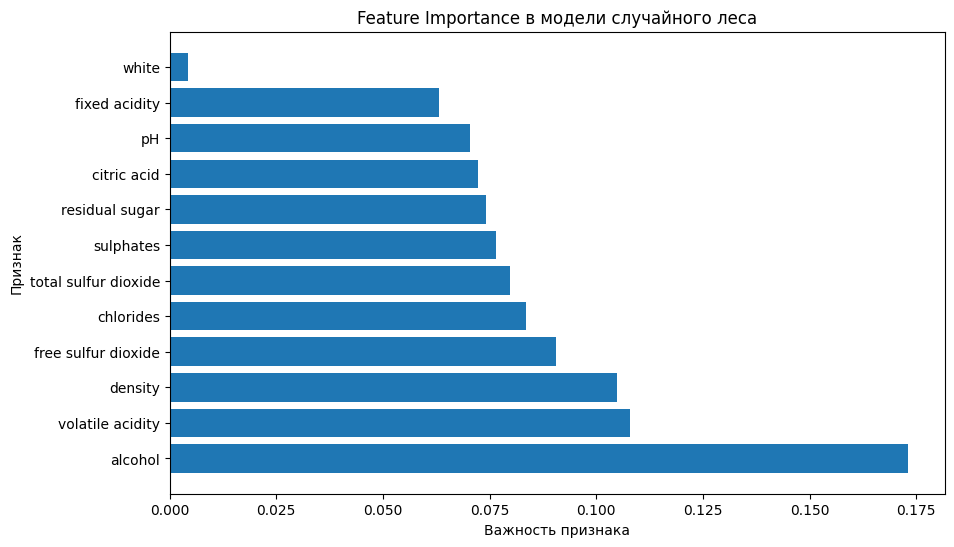

In [58]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Feature Importance в модели случайного леса')
plt.show()

In [62]:
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

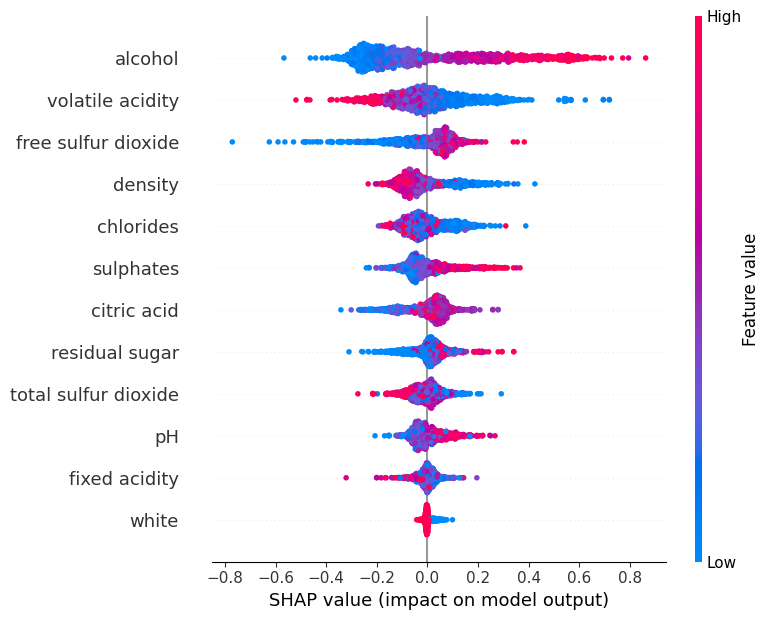

In [63]:
shap.summary_plot(shap_values, X_test)

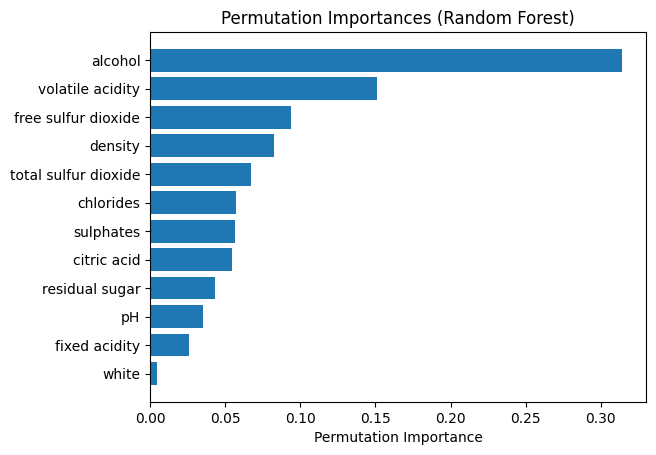

In [65]:
pi = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=19)

sorted_idx = pi.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], pi.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances (Random Forest)')
plt.show()